# 전처리 모듈 추가

In [33]:
from sklearn import preprocessing
#Null값 다른값으로 채우기
def fillna(df):
    df['Age'].fillna(df['Age'].mean(), inplace=True)
    df['Cabin'].fillna('N', inplace=True)
    df['Embarked'].fillna('N', inplace=True)
    df['Fare'].fillna(0, inplace=True)
    
    return df

#학습에 불필요한 feature 떨구기
def drop_features(df):
    df.drop(['PassengerId', 'Name', 'Ticket'], axis=1, inplace=True)
    return df

#레이블 인코딩 수행
def format_features(df):
    df['Cabin'] = df['Cabin'].str[:1]
    features = ['Cabin', 'Sex', 'Embarked']
    for feature in features:
        le = preprocessing.LabelEncoder()
        le = le.fit(df[feature])
        df[feature] = le.transform(df[feature])
        
    return df

#위의 3가지 데이터 전처리 함수를 호출하는 핸들링 함수
def transform_features(df):
    df = fillna(df)
    df = drop_features(df)
    df = format_features(df)
    return df

# 평가 

# 1. 정확도(Accuracy)
<p> : 정확도 = (예측 결과가 동일한 데이터 건수) / (전체 예측 데이터 건수) </p>
<p> 맹점> </p>
<p> 데이터 값의 레이블 값이 균일하지 못하고 한쪽으로 치우쳐진 데이터의 경우, 해당 데이터로만 예측하는 분류기가 있다고 하면 해당 분류기는 학습을 진행하지 않고도 매우 높은 정확도를 보일 것이다. 따라서 이를 가릴 다른 평가지표가 필요하다. </p>

## C.f) Classifier 커스터마이징
### : BaseEstimator를 상속받으면, Customized 형태의 Estimator를 개발자가 생성할 수 있다.

In [34]:
from sklearn.base import BaseEstimator
import numpy as np

class MyDummyClassifier(BaseEstimator):
    #아무것도 하지 않는 fit()
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        pred = np.zeros((X.shape[0], 1))
        for i in range(X.shape[0]):
            if X['Sex'].iloc[i] == 1: #남성인 경우, 무조건 사망으로 예측하도록 함
                pred[i] = 0
            else:
                pred[i] = 1
        return pred

In [35]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

titanic_df = pd.read_csv('Kaggle_Ex/titanic/train.csv')
y_titanic_df = titanic_df['Survived']
X_titanic_df = titanic_df.drop('Survived', axis=1)
X_titanic_df = transform_features(X_titanic_df)
X_train, X_test, y_train, y_test = train_test_split(X_titanic_df, y_titanic_df, test_size=0.2, random_state=0)

#위에서 새로 정의한 MyDummyClassifier를 이용해 학습을 진행
myclf = MyDummyClassifier()
myclf.fit(X_train, y_train)

mypred = myclf.predict(X_test)

print('Dummy Classifier의 정확도 : {0:.4f}'.format(accuracy_score(y_test, mypred)))

Dummy Classifier의 정확도 : 0.7877


단순히 남성인 경우 무조건 사망(0)으로 예측하도록 했음에도 불구하고, 정확도가 78%가 나왔다. 따라서 이 경우, 정확도는 이 데이터에서 학습알고리즘을 평가할 지표가 될 수 없음을 의미한다. 다른 방법으로 평가를 진행해야한다.

# 2. 오차 행렬

In [36]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, mypred)

array([[92, 18],
       [20, 49]])

confusion_matrix를 이용해 y_test와 "예측값"을 통해 구한 오차행렬을 행렬값으로 얻을 수 있다.

## - 정밀도(Precision)와 재현율(Recall)
* 정밀도 = TP / (FP + TP) <br>
=> 예측을 positive로 한 대상(FP+TP) 중에 예측과 실제 값이 positive로 일치(TP)한 데이터의 비율 <br>
<strong> 중요) 실제 Negative 인 데이터 에측을 positive로 잘못 판단하면 큰일 나는 경우 </strong><br>
* 재현율 = TP / (FN + TP) <br>
=> 실제 positive인 대상(FP+TP) 중에 예측과 실제 값이 positive로 일치(TP)한 데이터의 비율 <br>
<strong> 중요) 실제 positive 인 데이터 에측을 Negative로 잘못 판단하면 큰일 나는 경우에 상대적으로 중요해진다. </strong>

In [37]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

def get_clf_eval(y_test, pred):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    print('오차행렬')
    print(confusion)
    print('정확도 : {0:.4f}, 정밀도 : {1:.4f}, 재현율 : {2:.4f}'.format(accuracy, precision, recall))

In [38]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression #로지스틱 회귀 기반으로 학습을 진행한다.

itanic_df = pd.read_csv('Kaggle_Ex/titanic/train.csv')
y_titanic_df = titanic_df['Survived']
X_titanic_df = titanic_df.drop('Survived', axis=1)
X_titanic_df = transform_features(X_titanic_df)
X_train, X_test, y_train, y_test = train_test_split(X_titanic_df, y_titanic_df, test_size=0.2, random_state=0)

lr_clf = LogisticRegression(max_iter = 1000)

lr_clf.fit(X_train, y_train)
pred = lr_clf.predict(X_test)
get_clf_eval(y_test, pred)

오차행렬
[[92 18]
 [16 53]]
정확도 : 0.8101, 정밀도 : 0.7465, 재현율 : 0.7681


## - 정밀도, 재현율의 Trade-Off
둘은 상호보완적 관계로 한쪽이 오르면 한쪽은 감소하므로 임계값을 잘 조정하여 둘 모두가 최대로 높아지는 값을 찾아야한다.

In [39]:
pred_proba = lr_clf.predict_proba(X_test) #테스트 데이터 별로 0, 1로 예측한 결과를 확률로 보여준다.
pred = lr_clf.predict(X_test)
print('pred_proba() 결과 shape : {0}'.format(pred_proba.shape))
print('pred_proba array에서 앞 5개만 샘플로 추출\n', pred_proba[:5])

#예측확률과 결과를 함께 보여줌
pred_proba_result = np.concatenate([pred_proba, pred.reshape(-1, 1)], axis=1)
print('두 개의 class 중에서 더 큰 확률을 클래스 값으로 예측\n', pred_proba_result[:5])

pred_proba() 결과 shape : (179, 2)
pred_proba array에서 앞 5개만 샘플로 추출
 [[0.85372915 0.14627085]
 [0.89030403 0.10969597]
 [0.92560373 0.07439627]
 [0.05781867 0.94218133]
 [0.32140991 0.67859009]]
두 개의 class 중에서 더 큰 확률을 클래스 값으로 예측
 [[0.85372915 0.14627085 0.        ]
 [0.89030403 0.10969597 0.        ]
 [0.92560373 0.07439627 0.        ]
 [0.05781867 0.94218133 1.        ]
 [0.32140991 0.67859009 1.        ]]


임계값을 임의로 설정하기 위해 Binarizer 클래스를 이용한다. <br>
Binarizer 클래스는 input(행렬)의 각 값이 임계값보다 같거나 작으면 0, 크면 1을 반환한다.

In [40]:
from sklearn.preprocessing import Binarizer

#임계값 설정
custom_threshold = 0.5

#predict_proba() 반환값의 두번째 칼럼(1로 예측한 확률)만을 추출해 Binarizer를 적용해 최종 예측값을 구한다.
pred_proba_1 = pred_proba[:, 1].reshape(-1, 1)

binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_1)
custom_predict = binarizer.transform(pred_proba_1)

get_clf_eval(y_test, custom_predict) #임계값을 0.5로 설정 후 테스트 데이터와 비교한다.

오차행렬
[[92 18]
 [16 53]]
정확도 : 0.8101, 정밀도 : 0.7465, 재현율 : 0.7681


임계값이 0.5일 때, 임계값 설정없이 predict 했을 때와 정확히 결과가 동일함을 확인할 수 있다. <br>
이로부터 기본 임계값은 0.5임을 확인할 수 있다.

In [41]:
#임계값 설정
custom_threshold = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

def get_eval_by_threshold(y_test, pred_proba_c1, thresholds):
    for custom_threshold in thresholds:
        print("<임계값 : {0}>".format(custom_threshold))
        #predict_proba() 반환값의 두번째 칼럼(1로 예측한 확률)만을 추출해 Binarizer를 적용해 최종 예측값을 구한다.

        binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_c1)
        custom_predict = binarizer.transform(pred_proba_c1)

        get_clf_eval(y_test, custom_predict) #임계값을 0.5로 설정 후 테스트 데이터와 비교한다.
        
get_eval_by_threshold(y_test, pred_proba[:, 1].reshape(-1, 1), custom_threshold)

<임계값 : 0.1>
오차행렬
[[19 91]
 [ 3 66]]
정확도 : 0.4749, 정밀도 : 0.4204, 재현율 : 0.9565
<임계값 : 0.2>
오차행렬
[[69 41]
 [ 6 63]]
정확도 : 0.7374, 정밀도 : 0.6058, 재현율 : 0.9130
<임계값 : 0.3>
오차행렬
[[82 28]
 [10 59]]
정확도 : 0.7877, 정밀도 : 0.6782, 재현율 : 0.8551
<임계값 : 0.4>
오차행렬
[[86 24]
 [13 56]]
정확도 : 0.7933, 정밀도 : 0.7000, 재현율 : 0.8116
<임계값 : 0.5>
오차행렬
[[92 18]
 [16 53]]
정확도 : 0.8101, 정밀도 : 0.7465, 재현율 : 0.7681
<임계값 : 0.6>
오차행렬
[[99 11]
 [25 44]]
정확도 : 0.7989, 정밀도 : 0.8000, 재현율 : 0.6377
<임계값 : 0.7>
오차행렬
[[106   4]
 [ 34  35]]
정확도 : 0.7877, 정밀도 : 0.8974, 재현율 : 0.5072
<임계값 : 0.8>
오차행렬
[[110   0]
 [ 39  30]]
정확도 : 0.7821, 정밀도 : 1.0000, 재현율 : 0.4348
<임계값 : 0.9>
오차행렬
[[110   0]
 [ 51  18]]
정확도 : 0.7151, 정밀도 : 1.0000, 재현율 : 0.2609


임계값을 낮출수록 <strong>재현율</strong>이 올라라고, <strong>정밀도</strong>가 떨어지는 반면, <br>
이유 -> 더 쉽게 양성으로 예측하므로 상대적으로 양성을 음성으로 예측하는 비율이 감소하기 때문에 FP가 감소하기 때문이다. <br>
임계값을 높일수록 <strong>재현율</strong>은 떨어지고, <strong>정밀도</strong>는 올라가는 것을 확인할 수 있다. <br>
이유 -> 양성으로 예측하기가 어려워지므로, 양성을 음성으로 예측하는 비율이 증가하므로 FP가 증가하기 때문이다. <br>

### * precision_recall_curve()
### 위와 같이 임계값을 바꿔가면서 정밀도와 재현율을 계산해보는 것이 이미 API로 존재하므로 이를 이용하자.

In [42]:
from sklearn.metrics import precision_recall_curve

#레이블값이 1일 때, 예측확률을 뽑아낸다.
pred_proba_class1 = lr_clf.predict_proba(X_test)[:, 1]
#precision_recall_curve() 사용 방법
precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_class1)
print('반환된 분류 결정 임계값 배열의 shape : ', thresholds.shape)

#반환된 임계값 배열의 로우 크기가 166이므로, 샘플로 10건만 추출하되, 임곗값을 15단계로 추출
thr_index = np.arange(0, thresholds.shape[0], 15)
print('샘플 추출을 위한 임계값 배열의 index 10개 : ', thr_index)
print('샘플용 10개의 임계값 : ', np.round(thresholds[thr_index], 2))

#15단계로 추출된 임계값에 따른 정밀도와 재현율
print('샘플 임계값별 정밀도 : ', np.round(precisions[thr_index], 3))
print('샘플 임계값별 재현율 : ', np.round(recalls[thr_index], 3))

반환된 분류 결정 임계값 배열의 shape :  (166,)
샘플 추출을 위한 임계값 배열의 index 10개 :  [  0  15  30  45  60  75  90 105 120 135 150 165]
샘플용 10개의 임계값 :  [0.06 0.1  0.12 0.15 0.19 0.28 0.44 0.58 0.64 0.79 0.91 0.97]
샘플 임계값별 정밀도 :  [0.399 0.418 0.464 0.52  0.594 0.659 0.724 0.803 0.826 1.    1.    1.   ]
샘플 임계값별 재현율 :  [1.    0.957 0.928 0.928 0.913 0.87  0.797 0.71  0.551 0.449 0.232 0.014]


### 이를 시각화해보자

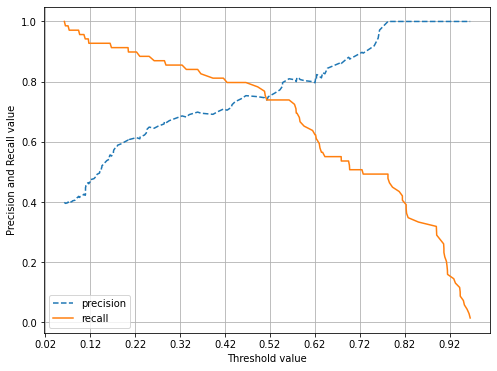

In [43]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

def precision_recall_curve_plot(y_test, pred_proba_c1):
    precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_c1)
    
    # X축:threshold값, y축:정밀도, 재현율 값으로 각각 plot 수행. 정밀도는 점선으로 표시
    plt.figure(figsize=(8,6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
    plt.plot(thresholds, recalls[0:threshold_boundary], label='recall')
    
    #threshold 값 X축의 scale을 0.1단위로 변경
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1), 2))
    
    #X축, Y축 label과 legend, 그리고 gird 설정
    plt.xlabel('Threshold value'); plt.ylabel('Precision and Recall value')
    plt.legend(); plt.grid()
    plt.show()
    
precision_recall_curve_plot(y_test, lr_clf.predict_proba(X_test)[:, 1])

로지스틱 회귀 기반의 타이타닉 생존자 예측 모델의 경우, 임계값이 약 0.45 지점에서 재현율과 정밀도가 비슷해지는 것을 확인할 수 있다.


### 결론 : 
### 재현율과 정밀도를 어느 한쪽이 커지도록 하면 절대 안된다. 물론 앞서 말했듯 상황에 맞게 어느 한쪽을 살짝 높이는 튜닝을 할 수 있겠지만, 그렇다고 어느 하나만을 강조하도록 임계값을 설정하면 안된다.

# 3. F1 스코어
## : 정밀도와 재현율을 적절히 조합해 분류의 종합적인 성능평가가 가능하도록 해주는 평가 
## -> 정밀도와 재현율이 어느한쪽으로 치우치지 않을 때 높은 값이 나오도록 설계됨

## - f1_score() API 이용

In [44]:
from sklearn.metrics import f1_score
f1 = f1_score(y_test, pred)
print('F1 스코어 : {0:.4f}'.format(f1))

F1 스코어 : 0.7571


## - 임계값에 따라 F1 스코어를 구하기

In [45]:
#f1 스코어를 추가하기 위해 재정의
def get_clf_eval(y_test, pred):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    #f1 스코어를 추가
    f1 = f1_score(y_test, pred)
    print('오차행렬')
    print(confusion)
    print('정확도 : {0:.4f}, 정밀도 : {1:.4f}, 재현율 : {2:.4f}, F1스코어 : {3:.4f}'.format(accuracy, precision, recall, f1))
    
thresholds = [0.4, 0.45, 0.50, 0.55, 0.60]
pred_proba = lr_clf.predict_proba(X_test)
get_eval_by_threshold(y_test, pred_proba[:, 1].reshape(-1, 1), thresholds)

<임계값 : 0.4>
오차행렬
[[86 24]
 [13 56]]
정확도 : 0.7933, 정밀도 : 0.7000, 재현율 : 0.8116, F1스코어 : 0.7517
<임계값 : 0.45>
오차행렬
[[91 19]
 [14 55]]
정확도 : 0.8156, 정밀도 : 0.7432, 재현율 : 0.7971, F1스코어 : 0.7692
<임계값 : 0.5>
오차행렬
[[92 18]
 [16 53]]
정확도 : 0.8101, 정밀도 : 0.7465, 재현율 : 0.7681, F1스코어 : 0.7571
<임계값 : 0.55>
오차행렬
[[98 12]
 [18 51]]
정확도 : 0.8324, 정밀도 : 0.8095, 재현율 : 0.7391, F1스코어 : 0.7727
<임계값 : 0.6>
오차행렬
[[99 11]
 [25 44]]
정확도 : 0.7989, 정밀도 : 0.8000, 재현율 : 0.6377, F1스코어 : 0.7097


임계값이 0.55까지는 지속적으로 증가하다가 0.6이 됬을 때 크게 감소함을 확인할 수 있다.

# 4. ROC 곡선과 AUC 스코어

## ROC(Receiver Operation Characterisitc Curve)
 : 머신러닝의 이진 분류 모델의 예측 성능을 판단하는 중요한 평가 지표. <br>
 FPR과 TPR을 동시에 파악함과 동시에 그래프가 대각선에서부터 얼마나 떨어져있는지(면적이 얼마나 1에 가까운지, AUC)를 보고 분류기의 성능을 알 수 있음. 이때 대각선은 분류기가 의미가 없는 경우를 의미한다. 예를 들어 랜덤으로 0, 1로 예측결과를 내는 경우가 해당한다. 또한 각 그래프 위에서의 점의 위치는 서로 다른 임계값에서의 FPR, TPR 값을 의미한다.

## - roc_curve() API를 이용해 구하기

In [46]:
from sklearn.metrics import roc_curve

pred_proba_class1 = lr_clf.predict_proba(X_test)[:, 1]

fprs, tprs, thresholds = roc_curve(y_test, pred_proba_class1)

#임계값의 개수가 56개이므로 임계값은 5씩 차이 나도록 설정하여 샘플로 11개를 추출한다.
# 주의! thresholds[0]은 max(예측확률)+1로 자동설정되므로 이를 제외하고자, 인덱스를 1부터 시작함
thr_index = np.arange(1, thresholds.shape[0], 5)
print('샘플 추출한 임계값 배열의 인덱스 11개 : ', thr_index)
print('샘플용 11개의 임계값 : ', np.round(thresholds[thr_index], 2))

print('샘플 임계값별 FPR : ', np.around(fprs[thr_index], 2))
print('샘플 임계값별 TPR : ', np.around(tprs[thr_index], 2))

샘플 추출한 임계값 배열의 인덱스 11개 :  [ 1  6 11 16 21 26 31 36 41 46 51]
샘플용 11개의 임계값 :  [0.97 0.7  0.63 0.58 0.42 0.32 0.23 0.16 0.12 0.11 0.07]
샘플 임계값별 FPR :  [0.   0.05 0.08 0.1  0.21 0.25 0.35 0.46 0.68 0.78 0.93]
샘플 임계값별 TPR :  [0.01 0.54 0.57 0.7  0.8  0.86 0.88 0.93 0.93 0.94 0.97]


임계값이 1에 가까울 수록 FPR이 줄고, 0에 가까울 수록 FPR이 증가함을 알 수 있다. 그리고 임계값이 1에서 멀어질 때, FPR의 증가량보다 TPR의 증가량이 큰것으로 보아 대각선에서 꽤 멀어지는 곡선을 보임을 생각할 수 있다.

### *시각화

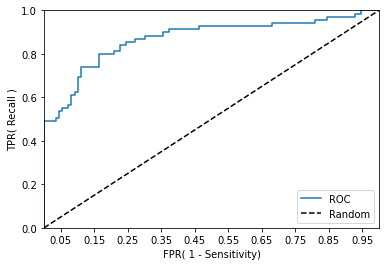

In [47]:
def roc_curve_plot(y_test, pred_proba_c1):
    fprs, tprs, thresholds = roc_curve(y_test, pred_proba_c1)
    #x축, y축을 fprs, tprs로 설정하고 해당 곡선은 ROC로 명명함.
    plt.plot(fprs, tprs, label='ROC')
    #대각선에 선을 그음
    plt.plot([0,1],[0,1],'k--', label='Random')
    
    #FPR (x축)의 스케일을 0.1단위로 변경, x, y 축 명 설정 등
    start, end = plt.xlim()
    plt.xticks(np.around(np.arange(start, end, 0.1), 2))
    plt.xlim(0, 1); plt.ylim(0, 1)
    plt.xlabel('FPR( 1 - Sensitivity)'); plt.ylabel('TPR( Recall )')
    plt.legend()
    
roc_curve_plot(y_test, pred_proba[:, 1])

### * get_clf_eval 함수에 roc_auc 스코어 추가하기 위해 재정의

In [49]:
from sklearn.metrics import roc_auc_score

def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    #f1 스코어를 추가
    f1 = f1_score(y_test, pred)
    #ROC-AUC 추가
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차행렬')
    print(confusion)
    print('정확도 : {0:.4f}, 정밀도 : {1:.4f}, 재현율 : {2:.4f}, F1스코어 : {3:.4f}, AUC : {4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))
    
get_clf_eval(y_test, pred, pred_proba[:, 1])

오차행렬
[[92 18]
 [16 53]]
정확도 : 0.8101, 정밀도 : 0.7465, 재현율 : 0.7681, F1스코어 : 0.7571, AUC : 0.8702
